In [ ]:
##############################################################################
# parameters #################################################################
##############################################################################
import numpy as np
import pandas as pd
from math import sqrt, exp, log
import sqlalchemy as sa
import ast
from datetime import datetime


##############################################################################
# class, function, generator definitions #####################################
##############################################################################

class ftrl_proximal(object):
    ''' Our main algorithm: Follow the regularized leader - proximal

        In short,
        this is an adaptive-learning-rate sparse logistic-regression with
        efficient L1-L2-regularization

        Reference:
        http://www.eecs.tufts.edu/~dsculley/papers/ad-click-prediction.pdf
    '''

    def __init__(self, alpha, beta, L1, L2, D, interaction):
        # parameters
        self.alpha = alpha
        self.beta = beta
        self.L1 = L1
        self.L2 = L2

        # feature related parameters
        self.D = D
        self.interaction = interaction

        # model
        # n: squared sum of past gradients
        # z: weights
        # w: lazy weights
        self.n = [0.] * D
        self.z = [0.] * D
        self.w = {}

    def _indices(self, x):
        ''' A helper generator that yields the indices in x

            The purpose of this generator is to make the following
            code a bit cleaner when doing feature interaction.
        '''

        # first yield index of the bias term
        yield 0

        # then yield the normal indices
        for index in x:
            yield index

        # now yield interactions (if applicable)
        if self.interaction:
            D = self.D
            L = len(x)

            x = sorted(x)
            for i in xrange(L):
                for j in xrange(i+1, L):
                    # one-hot encode interactions with hash trick
                    yield abs(hash(str(x[i]) + '_' + str(x[j]))) % D

    def predict(self, x):
        ''' Get probability estimation on x

            INPUT:
                x: features

            OUTPUT:
                probability of p(y = 1 | x; w)
        '''

        # parameters
        alpha = self.alpha
        beta = self.beta
        L1 = self.L1
        L2 = self.L2

        # model
        n = self.n
        z = self.z
        w = {}

        # wTx is the inner product of w and x
        wTx = 0.
        for i in self._indices(x):
            sign = -1. if z[i] < 0 else 1.  # get sign of z[i]

            # build w on the fly using z and n, hence the name - lazy weights
            # we are doing this at prediction instead of update time is because
            # this allows us for not storing the complete w
            if sign * z[i] <= L1:
                # w[i] vanishes due to L1 regularization
                w[i] = 0.
            else:
                # apply prediction time L1, L2 regularization to z and get w
                w[i] = (sign * L1 - z[i]) / ((beta + sqrt(n[i])) / alpha + L2)

            wTx += w[i]

        # cache the current w for update stage
        self.w = w

        # bounded sigmoid function, this is the probability estimation
        return 1. / (1. + exp(-max(min(wTx, 35.), -35.)))

    def update(self, x, p, y):
        ''' Update model using x, p, y

            INPUT:
                x: feature, a list of indices
                p: click probability prediction of our model
                y: answer

            MODIFIES:
                self.n: increase by squared gradient
                self.z: weights
        '''

        # parameter
        alpha = self.alpha

        # model
        n = self.n
        z = self.z
        w = self.w

        # gradient under logloss
        g = p - y

        # update z and n
        for i in self._indices(x):
            sigma = (sqrt(n[i] + g * g) - sqrt(n[i])) / alpha
            z[i] += g - sigma * w[i]
            n[i] += g * g


def logloss(p, y):
    ''' FUNCTION: Bounded logloss

        INPUT:
            p: our prediction
            y: real answer

        OUTPUT:
            logarithmic loss of p given y
    '''

    p = max(min(p, 1. - 10e-15), 10e-15)
    return -log(p) if y == 1. else -log(1. - p)


def data(query, engine, D):
    ''' GENERATOR: Apply hash-trick to the original csv row
                   and for simplicity, we one-hot-encode everything

        INPUT:
            path: path to training or testing file
            D: the max index that we can hash to

        YIELDS:
            ID: id of the instance, mainly useless
            x: a list of hashed and one-hot-encoded 'indices'
               we only need the index since all values are either 0 or 1
            y: y = 1 if we have a click, else we have y = 0
    '''
    stream = pd.read_sql(query, engine, chunksize = 1000)
    i = 0
    for chunk in stream:
        chunk = chunk.to_dict(orient = "records")
        for t, row in enumerate(chunk):
            # process id
            try:
                ID = row['TestId']
                del row['TestId']
            except:
                ID = 0

            # process clicks
            y = 0.
            if 'IsClick' in row:
                if row['IsClick'] == '1':
                    y = 1.
                del row['IsClick']

            # extract date
            date = row['SearchDate']


            # build x
            x = []
            for key in row:
                value = row[key]
                if not isinstance(value, unicode):
                    value = str(value)
                # one-hot encode everything with hash trick
                index = abs(hash(key + '_' + value)) % D
                x.append(index)

            yield t+i*1000, date, ID, x, y
        i += 1

In [1]:
from random import random

In [3]:
random() < 0.2

False

In [ ]:
from model import *

# A, paths
submission = 'submission1234.csv'  # path of to be outputted submission file

# B, model
alpha = .1  # learning rate
beta = 1.   # smoothing parameter for adaptive learning rate
L1 = 1.     # L1 regularization, larger value means more regularized
L2 = 1.     # L2 regularization, larger value means more regularized

# C, feature/hash trick
D = 2 ** 20             # number of weights to use
interaction = False     # whether to enable poly2 feature interactions

# D, training/validation
holdafter = False #datetime.strptime("2015-04-26", "%Y-%m-%d")   # data after date N (exclusive) are used as validation
#holdout = None  # use every N training instance for holdout validation

start = datetime.now()

# initialize ourselves a learner
learner = ftrl_proximal(alpha, beta, L1, L2, D, interaction)
engine = sa.create_engine('sqlite:///../input/database.sqlite')
loss = 0.
count = 0

query = "SELECT position, HistCTR, IsClick, AdsInfo.CategoryID AS acid, \
Price, date(SearchDate) AS SearchDate, IsUserLoggedOn, SearchQuery, SearchInfo.LocationID, \
SearchInfo.CategoryID, UserAgentOSID, UserDeviceID, c1.Level AS slevel, c2.Level AS alevel \
FROM trainSearchStream JOIN SearchInfo ON trainSearchStream.SearchID=SearchInfo.SearchID \
JOIN AdsInfo ON AdsInfo.AdID=trainSearchStream.AdID JOIN Category c1 ON c1.CategoryID=SearchInfo.CategoryID \
JOIN UserInfo ON UserInfo.UserID=SearchInfo.UserID JOIN Category c2 ON c2.CategoryID=AdsInfo.CategoryID \
WHERE ObjectType=3;"

for t, date, ID, x, y in data(query, engine, D):  # data is a generator
    #    t: just a instance counter
    # date: you know what this is
    #   ID: id provided in original data
    #    x: features
    #    y: label (click)

    # step 1, get prediction from learner
    p = learner.predict(x)
    loss += logloss(p, y)
    learner.update(x, p, y)
    if t %10000 == 0:
        print "{0:f}".format(loss/10000.)

print "start testing"
##############################################################################
# start testing, and build Kaggle's submission file ##########################
##############################################################################
query = "SELECT TestId, position, HistCTR, AdsInfo.CategoryID AS acid, \
    Price, date(SearchDate) AS SearchDate, IsUserLoggedOn, SearchQuery, SearchInfo.LocationID, \
    SearchInfo.CategoryID, UserAgentOSID, UserDeviceID, c1.Level AS slevel, c2.Level AS alevel \
    FROM testSearchStream LEFT JOIN SearchInfo ON testSearchStream.SearchID=SearchInfo.SearchID \
    LEFT JOIN AdsInfo ON AdsInfo.AdID=testSearchStream.AdID LEFT JOIN Category c1 ON c1.CategoryID=SearchInfo.CategoryID \
    LEFT JOIN UserInfo ON UserInfo.UserID=SearchInfo.UserID LEFT JOIN Category c2 ON c2.CategoryID=AdsInfo.CategoryID \
    WHERE ObjectType=3;"
with open(submission, 'w') as outfile:
    outfile.write('ID,IsClick\n')
    for t, date, ID, x, y in data(query, engine, D):
        p = learner.predict(x)
        p = "{0:f}"
        outfile.write('%s,%s\n' % (ID, p))

In [1]:
"{0:f}".format(0.00000124)

'0.000001'

In [ ]:
query = "SELECT position, HistCTR, IsClick, AdsInfo.CategoryID AS acid, \
Price, Title, SearchDate, IsUserLoggedOn, SearchQuery, SearchInfo.LocationID, \
SearchInfo.CategoryID, UserAgentOSID, UserDeviceID, c1.Level AS slevel, c2.Level AS alevel \
FROM trainSearchStream JOIN SearchInfo ON trainSearchStream.SearchID=SearchInfo.SearchID \
JOIN AdsInfo ON AdsInfo.AdID=trainSearchStream.AdID JOIN Category c1 ON c1.CategoryID=SearchInfo.CategoryID \
JOIN UserInfo ON UserInfo.UserID=SearchInfo.UserID JOIN Category c2 ON c2.CategoryID=AdsInfo.CategoryID \
WHERE ObjectType=3 LIMIT 500000;"

In [ ]:
stream = pd.read_sql(query, engine, chunksize = 1)
count =0
with open("sample.csv", "a") as output:
    for chunk in stream:
        chunk.to_csv(output, header = False, index = False, encoding ='utf-8')
        count += 1
        print count*10000

In [ ]:
stream = pd.read_sql(query, engine, chunksize = 10000)
count =0
with open("test.csv", "a") as output:
    for chunk in stream:
        chunk.to_csv(output, header = False, index = False, encoding ='utf-8')
        count += 1
        print count*10000

In [ ]:
class ftrl(object):
    def __init__(self, alpha, beta, l1, l2, bits):
        self.z = [0.] * bits
        self.n = [0.] * bits
        self.alpha = alpha
        self.beta = beta
        self.l1 = l1
        self.l2 = l2
        self.w = {}
        self.X = []
        self.y = 0.
        self.bits = bits
        self.Prediction = 0.

    def sgn(self, x):
        if x < 0:
            return -1  
        else:
            return 1

    def fit(self,line):
        try:
            self.ID = line['TestID']
            del line['TestID']
        except:
            pass

        try:
            self.y = float(line['IsClick'])
            del line['IsClick']
        except:
            pass

        for k in line.keys():
            if isinstance(line[k], basestring):
                line[k] = line[k]
            else:
                line[k] = str(line[k])       
        self.X = [0.] * len(line)
        for i, key in enumerate(line):
            val = line[key]
            if isinstance(key, basestring):
                self.X[i] = (abs(hash(key + '_' + val)) % self.bits)
            else:
                self.X[i] = (abs(hash(str(key) + '_' + val)) % self.bits)
        self.X = [0] + self.X

    def logloss(self):
        act = self.y
        pred = self.Prediction
        predicted = max(min(pred, 1. - 10e-15), 10e-15)
        return -log(predicted) if act == 1. else -log(1. - predicted)

    def predict(self):
        W_dot_x = 0.
        w = {}
        for i in self.X:
            if abs(self.z[i]) <= self.l1:
                w[i] = 0.
            else:
                w[i] = (self.sgn(self.z[i]) * self.l1 - self.z[i]) / (((self.beta + sqrt(self.n[i]))/self.alpha) + self.l2)
            W_dot_x += w[i]
        self.w = w
        self.Prediction = 1. / (1. + exp(-max(min(W_dot_x, 35.), -35.)))
        return self.Prediction

    def update(self, prediction): 
        for i in self.X:
            g = (prediction - self.y) #* i
            sigma = (1./self.alpha) * (sqrt(self.n[i] + g*g) - sqrt(self.n[i]))
            self.z[i] += g - sigma*self.w[i]
            self.n[i] += g*g

def clean(line):
    t = line["SearchDate"]
    t =  datetime.strptime(t, "%Y-%m-%d %H:%M:%S.0")
    line["SearchDate"] = t.month*30 + t.day
    line["hour"] = t.hour
    
    title = line["Title"].split(" ")
    del line["Title"]
    for t in title:
        line[t] = ""
    return line

In [ ]:
clf = ftrl(alpha = 0.1, 
               beta = 1., 
               l1 = 1.,
               l2 = 1.0, 
               bits = 2**25)

loss = 0.

In [ ]:
count = 0
# x is column names from sqlite
stream = pd.read_csv("sample.csv", header = False, chunksize = 1000, encoding='utf-8')
for chunk in stream:
    chunk.columns = x.columns
    for i in range(chunk.shape[0]):
        line = dict(chunk.loc[i,:])
        line = clean(line)
        clf.fit(line)
        pred = clf.predict()
        loss += clf.logloss()
        clf.update(pred)
        count += 1
        if count%10000 == 0: 
            print "Seen{},Loss {}".format(count, loss * 1./count)


count = 0
loss =0.
stream = pd.read_csv("test.csv", header = False, chunksize = 5000, encoding='utf-8')
for chunk in stream:
    count += 5000
    chunk.columns = x.columns
    for i in range(chunk.shape[0]):
        line = dict(chunk.loc[i,:])
        line = clean(line)
        clf.fit(line)
        pred = clf.predict()
        loss += clf.logloss()
    if count %10000 == 0:
        print "Finished %d predictions" %count
print "loss is {}".format(loss/count)

In [ ]:
query = "SELECT position, ObjectType, HistCTR, AdsInfo.CategoryID AS acid, Price, Title,\
SearchDate, IsUserLoggedOn, SearchQuery, SearchInfo.LocationID, SearchInfo.CategoryID, \
UserAgentOSID, UserDeviceID, c1.Level AS slevel, c2.Level AS alevel \
FROM testSearchStream LEFT JOIN SearchInfo ON testSearchStream.SearchID=SearchInfo.SearchID \
JOIN AdsInfo ON AdsInfo.AdID=testSearchStream.AdID JOIN Category c1 ON c1.CategoryID=SearchInfo.CategoryID \
JOIN UserInfo ON UserInfo.UserID=SearchInfo.UserID JOIN Category c2 ON c2.CategoryID=AdsInfo.CategoryID \
WHERE date(SearchInfo.SearchDate)='2015-05-12' LIMIT 300;"
stream = pd.read_sql(query, engine, chunksize = 1000)
count = 0
with open('temp.csv', 'w') as output:
    for chunk in stream:
        count += 5000
        for i in range(chunk.shape[0]):
            line = dict(chunk.loc[i,:])
            line = clean(line)
            clf.fit(line)
            output.write('%s\n' % str(clf.predict()))
        if count %10000 == 0:
            print "Finished %d predictions" %count

sample = pd.read_csv('../input/sampleSubmission.csv')
preds = np.array(pd.read_csv('temp.csv', header = None))
index = sample.ID.values - 1

sample['IsClick'] = preds[index]
sample.to_csv('submission2.csv', index=False)

In [ ]:
SELECT COUNT(*) FROM testSearchStream LEFT JOIN SearchInfo ON testSearchStream.SearchID=SearchInfo.SearchID LEFT JOIN AdsInfo ON AdsInfo.AdID=testSearchStream.AdID LEFT JOIN Category c1 ON SearchInfo.CategoryID=c1.CategoryID LEFT JOIN UserInfo ON UserInfo.UserID=SearchInfo.UserID LEFT JOIN Category c2 ON AdsInfo.CategoryID=c2.CategoryID

In [ ]:
from skimage import transform
from skimage import io
import numpy as np
import os
import pandas as pd


In [9]:
X_train = np.zeros([1600,3,128, 128])
y_train = np.zeros(1600)

In [ ]:
labels = pd.read_csv('../input/trainLabels.csv')

In [ ]:
folder = os.listdir('../input/train')
i = 0
for x in folder:
    cur = io.imread('../input/train/'+ x)
    cur = transform.resize(cur, (128, 128))
    cur = np.swapaxes(cur, 0, 2)
    X_train[i] = cur
    y_train[i] = int(labels.loc[labels.image == x[:-5],'level'])
    i += 1
    if i == 1600:
        break

In [ ]:
nb_classes = 5
nb_epoch = 3
batch_size = 16

In [ ]:
import numpy as np
import pandas as pd
import os
from skimage import transform
from skimage import io

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils, generic_utils
from keras.preprocessing.image import ImageDataGenerator
from six.moves import range

X_train = np.load("sample_train.npy")
Y_train = np.load('sample_y.npy')

nb_classes = 5
nb_epoch = 1
batch_size = 32

#y_train = y_train.reshape([1600,1])
#Y_train = np_utils.to_categorical(y_train, nb_classes)

model = Sequential()

model.add(Convolution2D(32, 3, 3, 3, border_mode='full')) 
model.add(Activation('relu'))
model.add(Convolution2D(32, 32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(poolsize=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64, 32, 3, 3, border_mode='full')) 
model.add(Activation('relu'))
model.add(Convolution2D(64, 64, 3, 3)) 
model.add(Activation('relu'))
model.add(MaxPooling2D(poolsize=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64*32*32, 512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(512, nb_classes))
model.add(Activation('softmax'))

# let's train the model using SGD + momentum (how original).
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd)


datagen = ImageDataGenerator(
    featurewise_center=True, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=True, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=20, # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2, # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2, # randomly shift images vertically (fraction of total height)
    horizontal_flip=True, # randomly flip images
    vertical_flip=False) # randomly flip images

X_train = X_train.astype("float32")
datagen.fit(X_train)
for e in range(nb_epoch):
        print('-'*40)
        print('Epoch', e)
        print('-'*40)
        print("Training...")
        # batch train with realtime data augmentation
        progbar = generic_utils.Progbar(X_train.shape[0])
        for X_batch, Y_batch in datagen.flow(X_train, Y_train):
            loss = model.train_on_batch(X_batch, Y_batch)
            progbar.add(X_batch.shape[0], values=[("train loss", loss)])

#X_train = X_train.astype("float32")
#model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch)

In [ ]:
import numpy as np
import pandas as pd
import os
from skimage import transform
from skimage import io
from keras.utils import np_utils
# Testing time
X_test = np.zeros([12800,3,128, 128])
y_test = np.zeros(12800)

labels = pd.read_csv('../input/trainLabels.csv')

folder = os.listdir('../input/train')
i = 0
for x in reversed(folder):
    cur = io.imread('../input/train/'+ x)
    cur = transform.resize(cur, (128, 128))
    cur = np.swapaxes(cur, 0, 2)
    X_test[i] = cur
    y_test[i] = int(labels.loc[labels.image == x[:-5],'level'])
    i += 1
    if i == 12800:
        break

Y_test = np_utils.to_categorical(y_test, 5)
np.save("X_test", X_test)
np.save('y_test', Y_test)

In [23]:
from skimage import transform
from skimage import io

In [28]:
aa = io.imread('/Users/yupei/Documents/Kaggle/Diabetic_retinopathy/input/10000_left.jpeg')

In [29]:
aa.shape

(256, 256, 3)

Populating the interactive namespace from numpy and matplotlib


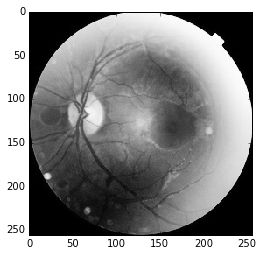

In [33]:
%pylab inline
io.imshow(rgb2gray(aa))

In [31]:
bb = np.swapaxes(aa, 0, 2)

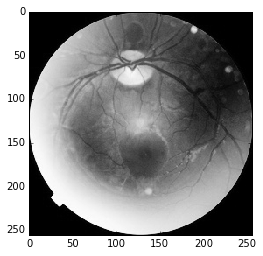

In [35]:
io.imshow(rgb2gray2(bb))

In [32]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [34]:
def rgb2gray2(rgb):

    r, g, b = rgb[0,:,:], rgb[1,:,:], rgb[2,:,:]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [ ]:
preds = model.predict(X_train)

In [ ]:
# THEANO_FLAGS='floatX=float32,device=gpu0,nvcc.fastmath=True' python cnn.py

In [1]:
import numpy as np

In [12]:
x = np.array([[[0,1,2], [3,4,5]], [[6,7,8], [9,10,11]], [[12,13,14], [15,16,17]], [[18,19,20], [21,22,23]]])

In [13]:
x.shape

(4, 2, 3)

In [22]:
np.swapaxes(x, 0,2)

array([[[ 0,  6, 12, 18],
        [ 3,  9, 15, 21]],

       [[ 1,  7, 13, 19],
        [ 4, 10, 16, 22]],

       [[ 2,  8, 14, 20],
        [ 5, 11, 17, 23]]])

In [14]:
x.flatten('F')

array([ 0,  6, 12, 18,  3,  9, 15, 21,  1,  7, 13, 19,  4, 10, 16, 22,  2,
        8, 14, 20,  5, 11, 17, 23])

In [15]:
y = x.flatten('F')

In [19]:
np.reshape(y, (3,2,4), 'C')

array([[[ 0,  6, 12, 18],
        [ 3,  9, 15, 21]],

       [[ 1,  7, 13, 19],
        [ 4, 10, 16, 22]],

       [[ 2,  8, 14, 20],
        [ 5, 11, 17, 23]]])